## Precipitation

### Set-up

In [7]:
# Load libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, udf, stddev
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Start session
spark = SparkSession\
        .builder\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "4g")\
        .getOrCreate()

23/06/08 10:52:04 WARN Utils: Your hostname, Shaolongs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.167 instead (on interface en0)
23/06/08 10:52:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 10:52:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read data
path = "/Users/shaolongxue/Documents/MSBA/3_Spring_Quarter/BAX423_Big_Data_Analytics/Final Project/Data/US_Traffic_v02.csv"
data = spark.read.format('csv').option('header', 'true').load(path)

In [48]:
# Select relevant features
cols_to_remove = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", 
                  "Number", "Street", "Country", "Timezone", "Airport_Code", "Zipcode", 
                  "Weather_Timestamp", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", 
                  "Astronomical_Twilight", "Weather_Condition", "Wind_Direction"]

df = data.select([col for col in data.columns if col not in cols_to_remove])

df = df.na.drop()

# Cast numeric columns to appropriate types
double_columns = ["Distance(mi)", "Temperature(F)", "Wind_Chill(F)", 
                   "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
                   "Wind_Speed(mph)", "Precipitation(in)", "Duration"]

integer_columns = ["Population", "Start_Year", "Start_Month"]

for column in double_columns:
    df = df.withColumn(column, col(column).cast("double"))

for column in integer_columns:
    df = df.withColumn(column, col(column).cast("integer"))

# Remove one outlier row wither Side is "N"
df = df.where(df.Side != 'N')
# Remove outliers where duration is larger than 7 days
df = df.where(df.Duration <= 168)

# Encode binary categorical columns
binary_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

for column in binary_columns:
    df = df.withColumn(column, when(col(column) == "true", 1).otherwise(0))

df = df.withColumn("Side", when(col("Side") == "L", 1).otherwise(0))

# Convert values in Start_TOD_Category column [Necessary for SMOTE]
df = df.withColumn("Start_TOD_Category",
                    when(df["Start_TOD_Category"] == "Midnight", "1")
                   .when(df["Start_TOD_Category"] == "Early Morning", "2")
                   .when(df["Start_TOD_Category"] == "Late Morning", "3")
                   .when(df["Start_TOD_Category"] == "Early Afternoon", "4")
                   .when(df["Start_TOD_Category"] == "Late Afternoon", "5")
                   .when(df["Start_TOD_Category"] == "Evening", "6"))

# First convert the categories from 'string' to 'index'
indexer = StringIndexer(inputCol="Start_TOD_Category", outputCol="Start_TOD_Category_index")
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol="Start_Weekday", outputCol="Start_Weekday_index")
df = indexer.fit(df).transform(df)

# Then one-hot encode these indices
encoder = OneHotEncoder(inputCols=["Start_TOD_Category_index", "Start_Weekday_index"],
                        outputCols=["Start_TOD_Category_vec", "Start_Weekday_vec"])
model = encoder.fit(df)
df = model.transform(df)

### EDA

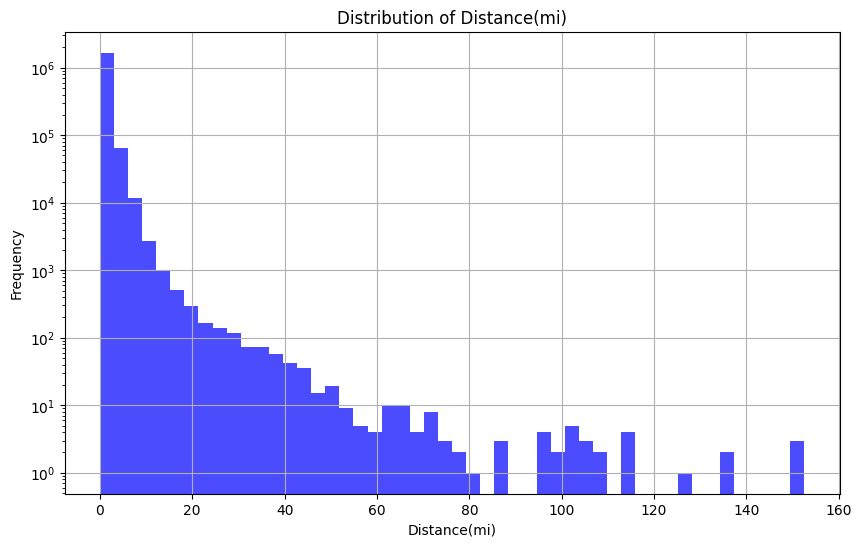

In [49]:
distance = df.select("Distance(mi)").dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(distance, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Distance(mi)')
plt.xlabel('Distance(mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

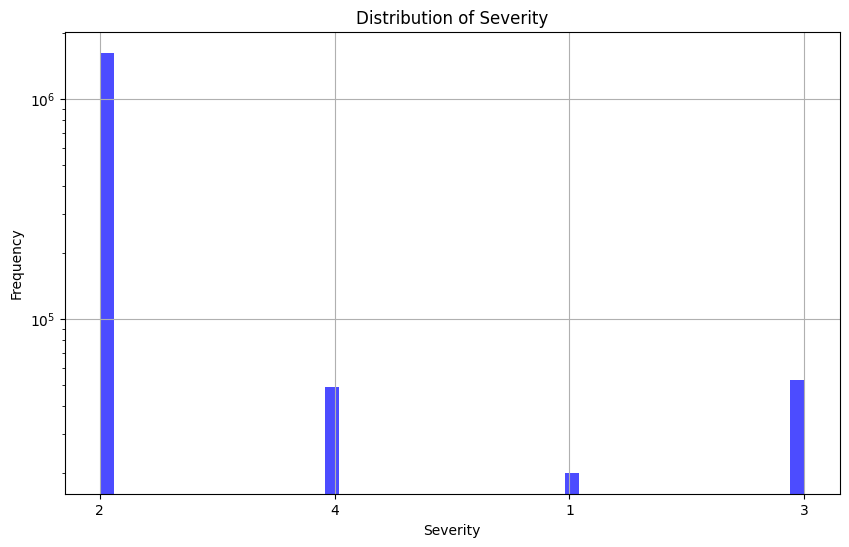

In [50]:
seve = df.select("Severity").dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(seve, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Severity')
plt.xlabel('Severity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

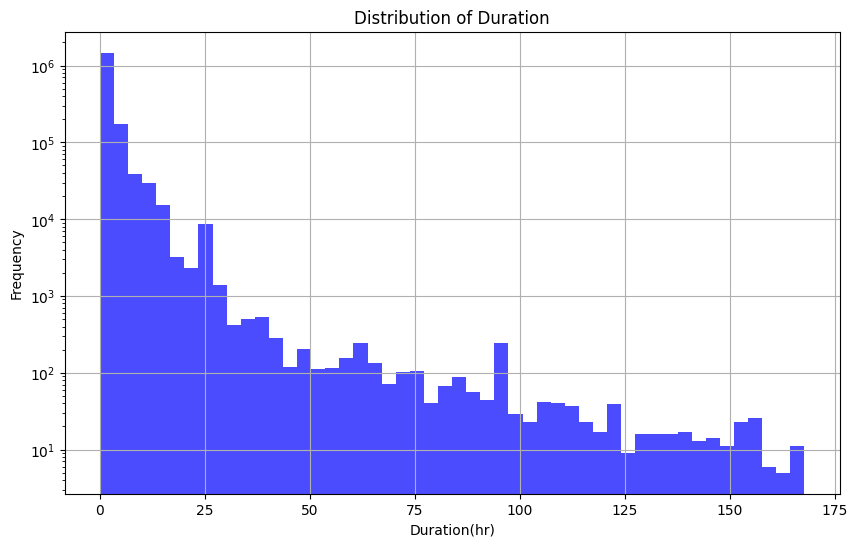

In [51]:
duration = df.select("Duration").dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(duration, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Duration')
plt.xlabel('Duration(hr)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

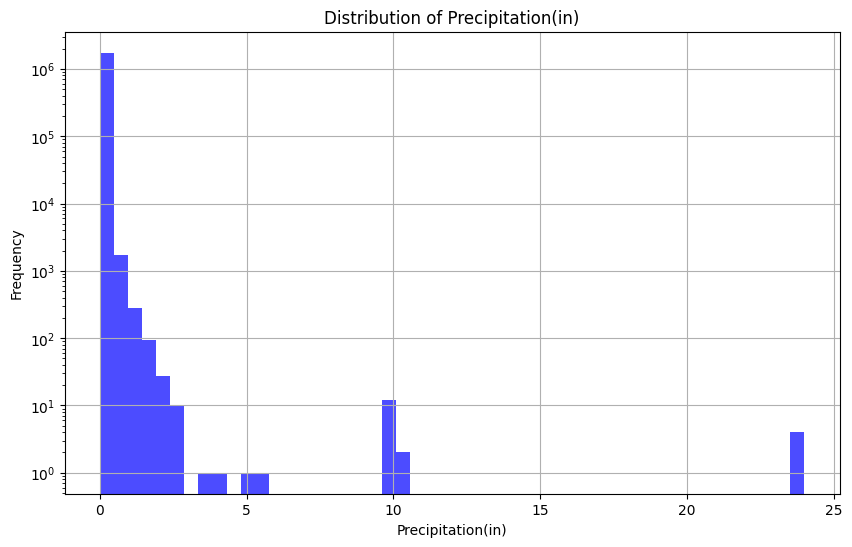

In [52]:
# First, convert the precipitation data to a list in your local environment
precipitation_data = df.select('Precipitation(in)').dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(precipitation_data, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Precipitation(in)')
plt.xlabel('Precipitation(in)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [53]:
# Calculate summary stats
rain_median = df.stat.approxQuantile('Precipitation(in)', [0.5], 0)[0]
rain_mean = df.agg(F.avg('Precipitation(in)')).first()[0]
rain_sd = df.agg(stddev("Precipitation(in)")).collect()[0][0]
print("Precipitation median = ", rain_median)
print("Precipitation mean = ", round(rain_mean, 3))
print("Precipitation standard dev = ", round(rain_sd, 3))

Precipitation median =  0.0
Precipitation mean =  0.005
Precipitation standard dev =  0.061


In [54]:
# Create treatment variables
df = df.withColumn('Rained', when(df['Precipitation(in)'] >= 0.1, 1).otherwise(0))

# Check balance
print("Treatment & Control Group Balance:")
print(df.groupBy("Rained").count().show())

Treatment & Control Group Balance:


+------+-------+
|Rained|  count|
+------+-------+
|     1|  26499|
|     0|1719037|
+------+-------+

None


In [55]:
df.show(10)

+-------+--------+--------------------+--------------------+--------------------+----+------------+--------------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+----------+----------+-----------+-------------+------------------+--------+------------------------+-------------------+----------------------+-----------------+------+
|     ID|Severity|          Start_Time|            End_Time|        Distance(mi)|Side|        City|        County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Population|Start_Year|Start_Month|Start_Weekday|Start_TOD_Category|Duration|Start_TOD_Category_index|Start_Weekday_index|Start_TOD_Categ

### Definitions



1. Target column: Severity / Duration / Distance(mi)

2. Treatment & Control group:
    * treatment: precipitation >= 0.1 inch (including light, moderate, and heavy rain)
    * control: precipitation < 0.1 inch

    * How I selected the threshold? 
        * Source: https://www.weathershack.com/static/ed-rain-measurement.html#:~:text=Rainfall%20rate%20is%20generally%20described,inches%20of%20rain%20per%20hour
    
3. Covariates
    * Side, Wind_Chill(F), Pressure(in), Wind_Speed(mph), Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop, Population, Start_Weekday, Start_TOD_Category
    * Rationale: I don't want to choose variables that highly correlate with precipication. For example, visibility and humidity is almost a direct outcome of rain. I want to choose covariates that has almost nothing to do with precipitation. 
    * excluded: visibility, humidity, temperature

In [90]:
# Undersample majority class (Rained = 0)
df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=0.2, seed=1) 
df_minor = df.filter(F.col("Rained") == 1)
df_balanced = df_minor.union(df_major)
print("Adjusted Treatment & Control Group Balance:")
print(df_balanced.groupBy("Rained").count().show())

Adjusted Treatment & Control Group Balance:


+------+------+
|Rained| count|
+------+------+
|     1| 26499|
|     0|343373|
+------+------+

None


### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [105]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "Rained"] + covariates

In [107]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Rained") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'Rained', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Rained', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Rained'] == 1]
    df_control = ps_pd[ps_pd['Rained'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.641


ATE = 0.02


Fraction =  0.1


AUC = 0.639


ATE = 0.035


Fraction =  0.2


AUC = 0.641


ATE = 0.0148


Fraction =  0.3


AUC = 0.64


ATE = 0.0104


Fraction =  0.4


AUC = 0.641


ATE = 0.0157


Fraction =  0.5


AUC = 0.642


ATE = 0.0104


Fraction =  0.6


AUC = 0.642


ATE = 0.0151


Fraction =  0.7


AUC = 0.642


ATE = 0.016


Fraction =  0.8


AUC = 0.642


ATE = 0.0112


#### Summary

The average treatment effect of precipitation on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is 0.035 unit. 

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [108]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "Rained"] + covariates

In [109]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Rained") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'Rained', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Rained', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Rained'] == 1]
    df_control = ps_pd[ps_pd['Rained'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.642


ATE = -0.4879


Fraction =  0.1


AUC = 0.643


ATE = -0.3666


Fraction =  0.2


AUC = 0.642


ATE = -0.4463


Fraction =  0.3


AUC = 0.643


ATE = -0.4459


Fraction =  0.4


AUC = 0.641


ATE = -0.4827


Fraction =  0.5


AUC = 0.64


ATE = -0.389


Fraction =  0.6


AUC = 0.643


ATE = -0.3706


Fraction =  0.7


AUC = 0.642


ATE = -0.3737


Fraction =  0.8


AUC = 0.642


ATE = -0.452


#### Summary

The average treatment effect of precipitation on accident duration (measured in hours) is -0.49 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [110]:
fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Population', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "Rained"] + covariates

In [111]:
from sklearn.neighbors import NearestNeighbors

for i in fraction:
    print("\n")
    print("Fraction = ", i)
    df_major = df.filter(F.col("Rained") == 0).sample(withReplacement=False, fraction=i, seed=1) 
    df_minor = df.filter(F.col("Rained") == 1)
    df_balanced = df_minor.union(df_major)
    df_ps = df_balanced.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='Rained', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'Rained', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='Rained', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['Rained'] == 1]
    df_control = ps_pd[ps_pd['Rained'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))
    
    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Fraction =  0.05


AUC = 0.645


ATE = 0.1948


Fraction =  0.1


AUC = 0.645


ATE = 0.0214


Fraction =  0.2


AUC = 0.644


ATE = 0.1278


Fraction =  0.3


AUC = 0.645


ATE = 0.1384


Fraction =  0.4


AUC = 0.646


ATE = 0.1333


Fraction =  0.5


AUC = 0.645


ATE = 0.1145


Fraction =  0.6


AUC = 0.646


ATE = 0.0895


Fraction =  0.7


AUC = 0.645


ATE = 0.0547


Fraction =  0.8


AUC = 0.645


ATE = 0.1131


#### Summary

The average treatment effect of precipitation on accident distance impacted (measured in miles) is 0.2 miles. 